In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog
% matplotlib inline

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if file[-4:] == ".png":
            image = np.uint8(image*255)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [2]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1 and svc.decision_function(test_features)>0.6:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [3]:
# Read in cars and notcars
vehicles_images = glob.glob('vehicles/*/*.png')
non_vehicles_images = glob.glob('non-vehicles/*/*.png')

cars = []
notcars = []

for image in vehicles_images:
    cars.append(image)
    
for image in non_vehicles_images:
    notcars.append(image)

# The number of cars and non-cars samples is balanced, which is good for fitting the model
print ("Number of Car Samples:",len(cars))
print ("Number of non-Car Samples:",len(notcars))

Number of Car Samples: 8792
Number of non-Car Samples: 8968


In [4]:
### TODO: Tweak these parameters and see how the results change.
# Tune and find the best parameter
# I tried different hyper-parameters and found the following parameters works best

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [5]:
# Extract features from traning samples

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t1=time.time()
print(round(t1-t, 2), 'Seconds to extract car features...')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2=time.time()
print(round(t2-t1, 2), 'Seconds to extract non-car features...')

38.95 Seconds to extract car features...
37.19 Seconds to extract non-car features...


In [6]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

16.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9921


In [16]:
def multi_window_search(image):
    
    #x_start_stop=[600, 1000]
    y_start_stop = [400, 650]      # Min and max in y to search in slide_window()
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.8, 0.8))
    hot_windows=search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    y_start_stop = [400, 650]      # Min and max in y to search in slide_window()
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    hot_windows.extend(search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))
    
    y_start_stop = [400, 650]      # Min and max in y to search in slide_window()
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.8))
    hot_windows.extend(search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))
    
    return hot_windows

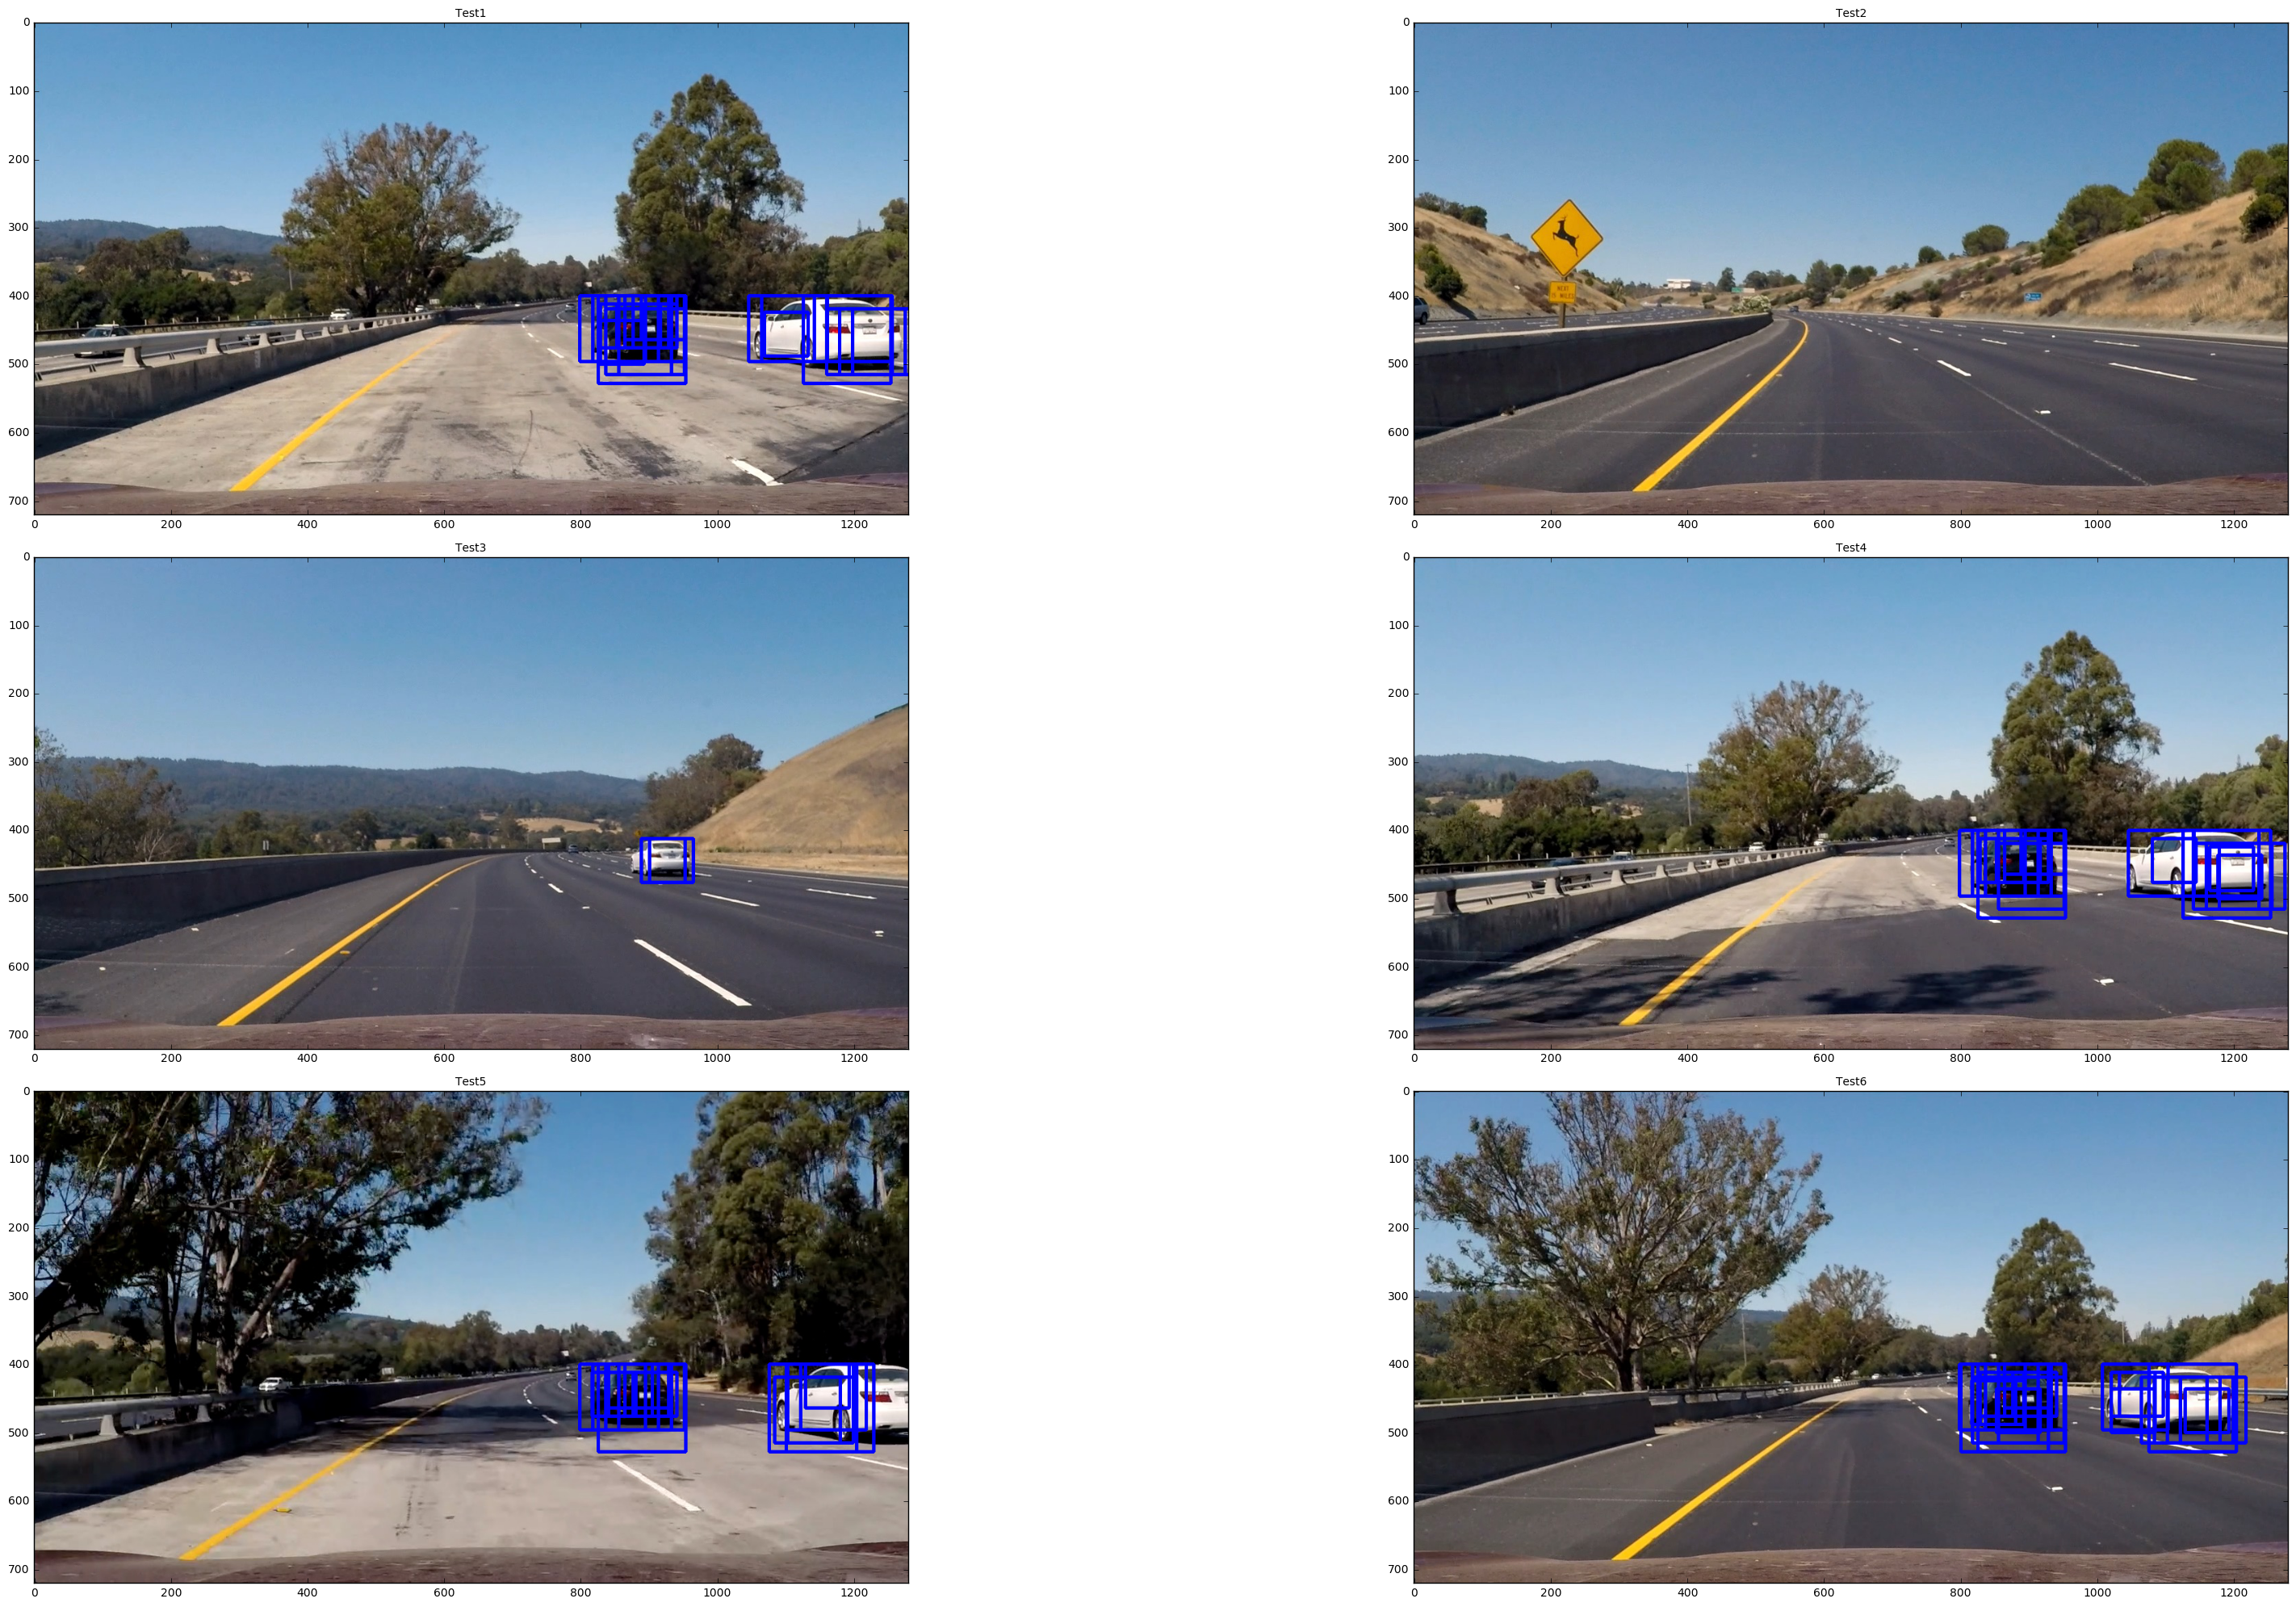

In [17]:
image1 = mpimg.imread('test_images/test1.jpg')
hot_windows1 = multi_window_search(image1)
image1_hotwindows = draw_boxes(image1, hot_windows1, color=(0, 0, 255), thick=3)

image2 = mpimg.imread('test_images/test2.jpg')
hot_windows2 = multi_window_search(image2)
image2_hotwindows = draw_boxes(image2, hot_windows2, color=(0, 0, 255), thick=3)

image3 = mpimg.imread('test_images/test3.jpg')
hot_windows3 = multi_window_search(image3)
image3_hotwindows = draw_boxes(image3, hot_windows3, color=(0, 0, 255), thick=3)

image4 = mpimg.imread('test_images/test4.jpg')
hot_windows4 = multi_window_search(image4)
image4_hotwindows = draw_boxes(image4, hot_windows4, color=(0, 0, 255), thick=3)

image5 = mpimg.imread('test_images/test5.jpg')
hot_windows5 = multi_window_search(image5)
image5_hotwindows = draw_boxes(image5, hot_windows5, color=(0, 0, 255), thick=3)

image6 = mpimg.imread('test_images/test6.jpg')
hot_windows6 = multi_window_search(image6)
image6_hotwindows = draw_boxes(image6, hot_windows6, color=(0, 0, 255), thick=3)
  

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(40,20))
ax1.imshow(image1_hotwindows)
ax1.set_title('Test1', fontsize=10)
ax2.imshow(image2_hotwindows)
ax2.set_title('Test2', fontsize=10)

ax3.imshow(image3_hotwindows)
ax3.set_title('Test3', fontsize=10)
ax4.imshow(image4_hotwindows)
ax4.set_title('Test4', fontsize=10)

ax5.imshow(image5_hotwindows)
ax5.set_title('Test5', fontsize=10)
ax6.imshow(image6_hotwindows)
ax6.set_title('Test6', fontsize=10)

plt.tight_layout()

In [ ]:
# Now we have to cluster the boxes and draw a single bounding box

In [10]:
# Creat heatmap for the region detected
def add_heat(image, bbox_list):
    heatmap = np.zeros_like(image[:,:,0])
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

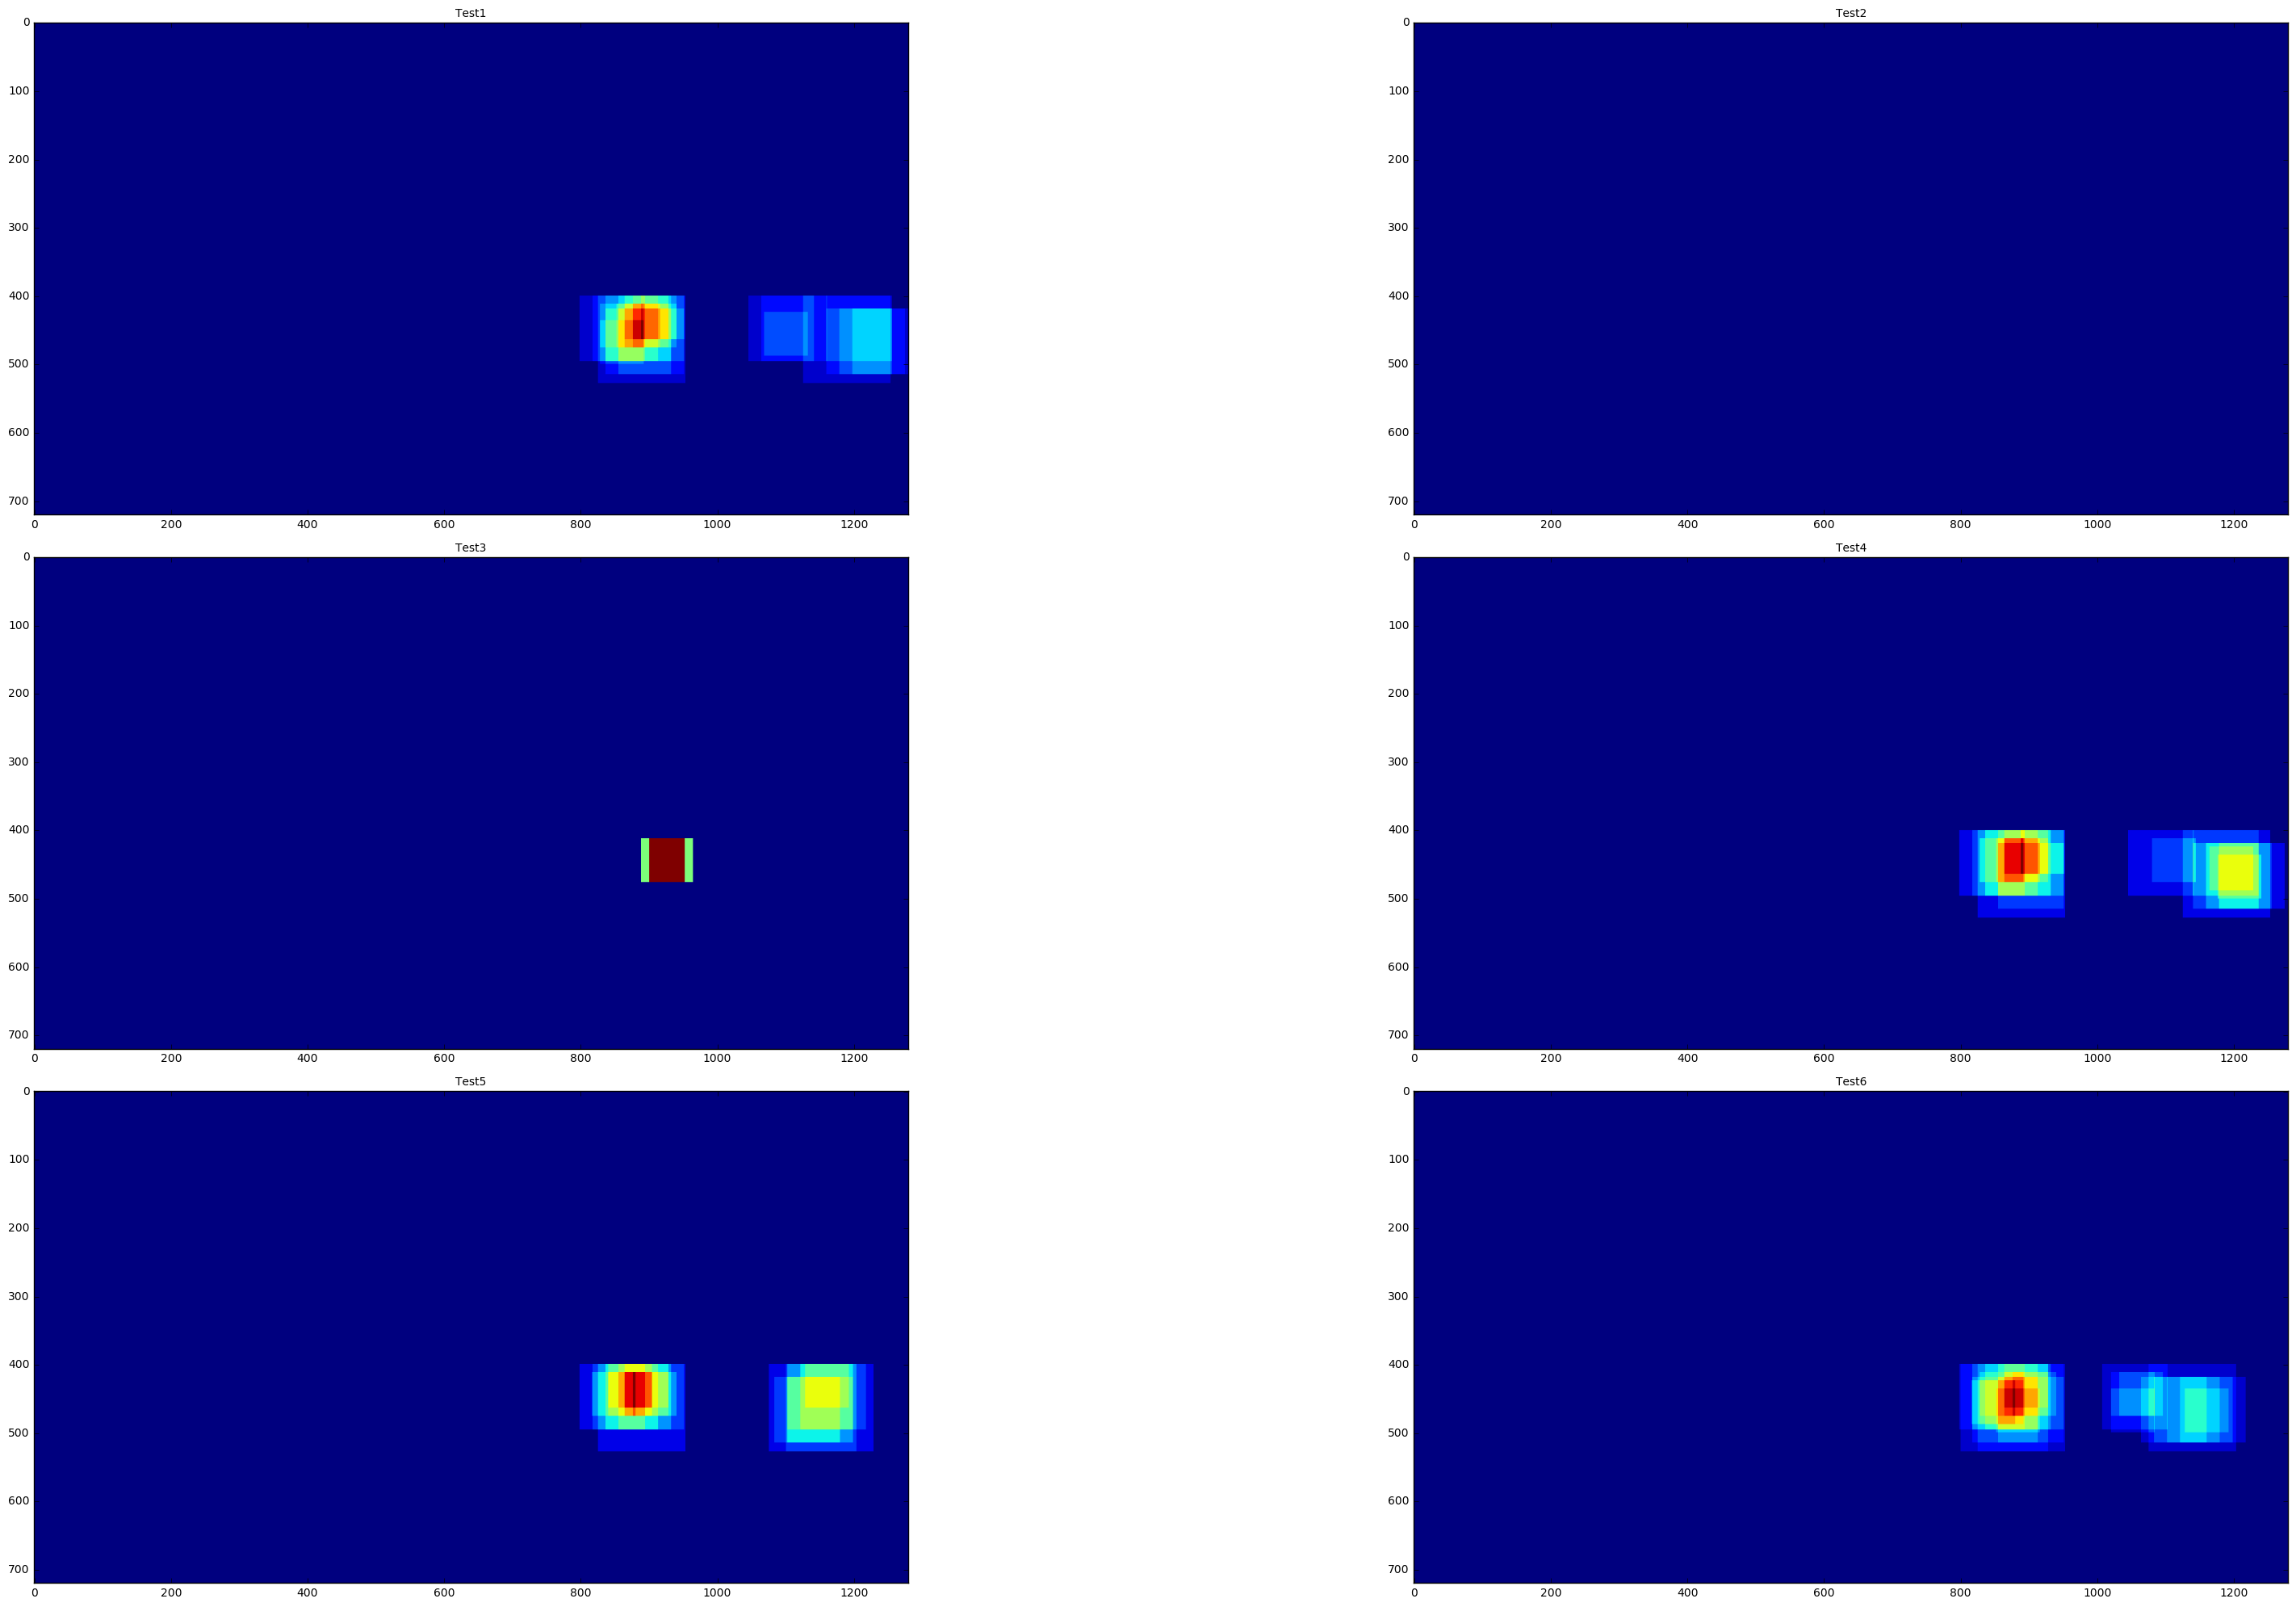

In [11]:
# Samples heatmaps for test images
heatmap1= add_heat(image1, hot_windows1)
heatmap2= add_heat(image2, hot_windows2)
heatmap3= add_heat(image3, hot_windows3)
heatmap4= add_heat(image4, hot_windows4)
heatmap5= add_heat(image5, hot_windows5)
heatmap6= add_heat(image6, hot_windows6)


f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(40,20))
ax1.imshow(heatmap1)
ax1.set_title('Test1', fontsize=10)
ax2.imshow(heatmap2)
ax2.set_title('Test2', fontsize=10)

ax3.imshow(heatmap3)
ax3.set_title('Test3', fontsize=10)
ax4.imshow(heatmap4)
ax4.set_title('Test4', fontsize=10)

ax5.imshow(heatmap5)
ax5.set_title('Test5', fontsize=10)
ax6.imshow(heatmap6)
ax6.set_title('Test6', fontsize=10)

plt.tight_layout()

In [12]:
# Threshold image
from scipy.ndimage.measurements import label
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

3 cars found


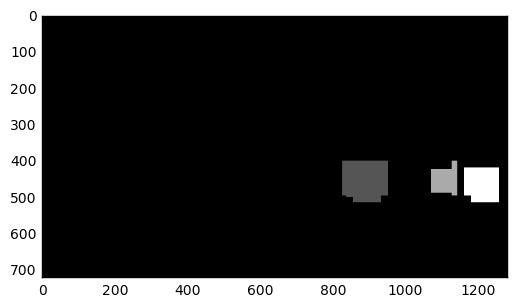

In [15]:
heatmap1 = apply_threshold(heatmap1, 2)
labels = label(heatmap1)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [18]:
def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bbox = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    return bbox

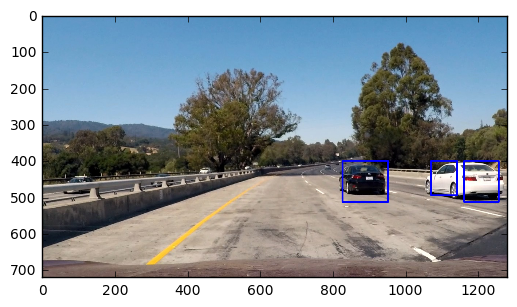

In [19]:
bbox = get_labeled_bboxes(labels)
draw_img = draw_boxes(image1, bbox, color=(0, 0, 255), thick=3)

# Display the image
plt.imshow(draw_img)

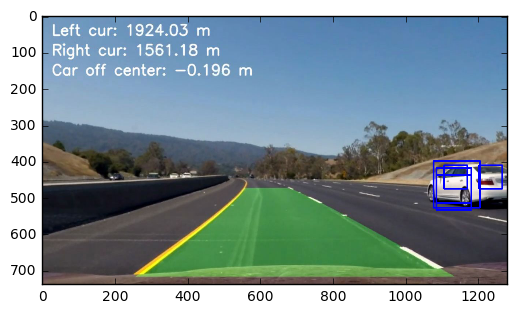

In [20]:
test = mpimg.imread('test_images2/test1.jpg')
hot_windows = multi_window_search(test)
test_hotwindows = draw_boxes(test, hot_windows, color=(0, 0, 255), thick=3)
plt.imshow(test_hotwindows)

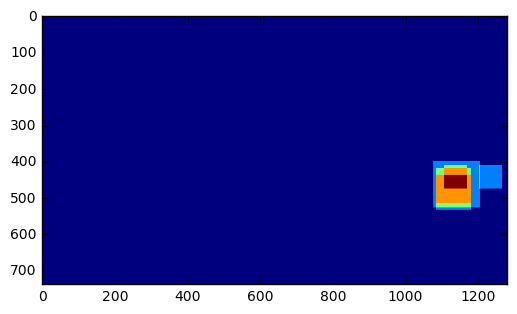

In [21]:
heatmap = add_heat(test, hot_windows)
plt.imshow(heatmap)

1 cars found


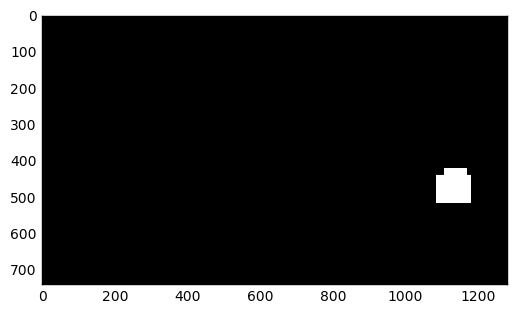

In [22]:
heatmap = apply_threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

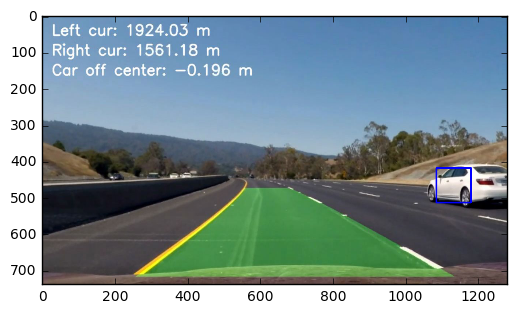

In [23]:
bbox = get_labeled_bboxes(labels)
draw_img = draw_boxes(test, bbox, color=(0, 0, 255), thick=3)

# Display the image
plt.imshow(draw_img)

In [ ]:
# Define
def detect_vehicles(img):
    hot_windows = multi_window_search(img)
    heatmap = add_heat(img, hot_windows)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)   
    bboxes = get_labeled_bboxes(labels)
    result = draw_boxes(img, bboxes, color=(0, 0, 255), thick=5)   
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Tracking '+ str(labels[1]) + ' Cars' 
    result = cv2.putText(result,text,(870,60), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return result    

In [ ]:
test = mpimg.imread('test_images2/test4.jpg')
result = detect_vehicles(test)
plt.imshow(result)

In [ ]:
test_img = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(test_img):
    img = mpimg.imread(fname)
    img_with_vehicles =  detect_vehicles(img)
    img_with_vehicles = cv2.cvtColor(img_with_vehicles, cv2.COLOR_RGB2BGR)
    write_name = 'test_images/'+'vehicles_found'+str(idx+1)+'.jpg'
    cv2.imwrite(write_name, img_with_vehicles)

In [ ]:
#Test Results
test1 = mpimg.imread('test_images/vehicles_found1.jpg')
test2 = mpimg.imread('test_images/vehicles_found2.jpg')
test3 = mpimg.imread('test_images/vehicles_found3.jpg')
test4 = mpimg.imread('test_images/vehicles_found4.jpg')
test5 = mpimg.imread('test_images/vehicles_found5.jpg')
test6 = mpimg.imread('test_images/vehicles_found6.jpg')

  

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(40,20))
ax1.imshow(test1)
ax1.set_title('Test1', fontsize=10)
ax2.imshow(test2)
ax2.set_title('Test2', fontsize=10)

ax3.imshow(test3)
ax3.set_title('Test3', fontsize=10)
ax4.imshow(test4)
ax4.set_title('Test4', fontsize=10)

ax5.imshow(test5)
ax5.set_title('Test5', fontsize=10)
ax6.imshow(test6)
ax6.set_title('Test6', fontsize=10)

plt.tight_layout()



In [ ]:
video_imgs = glob.glob('video_images/*.jpg')

for idx, fname in enumerate(video_imgs):
    img = mpimg.imread(fname)
    img_with_vehicles =  detect_vehicles(img)
    img_with_vehicles = cv2.cvtColor(img_with_vehicles, cv2.COLOR_RGB2BGR)
    write_name = 'video_images/'+'vehicles_found'+str(idx+1)+'.jpg'
    cv2.imwrite(write_name, img_with_vehicles)

In [24]:
import collections
heatmaps = collections.deque(maxlen=10)

def detect_vehicles_video(img):
    hot_windows = multi_window_search(img)
    current_heatmap = add_heat(img, hot_windows)
    heatmaps.append(current_heatmap)
    heatmap_sum = sum(heatmaps)
    heatmap_sum = apply_threshold(heatmap_sum, 5)
    labels = label(heatmap_sum)   
    bboxes = get_labeled_bboxes(labels)
    result = draw_boxes(img, bboxes, color=(0, 0, 255), thick=5)   
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Tracking '+ str(labels[1]) + ' Cars' 
    result = cv2.putText(result,text,(870,60), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return result    

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
output = 'project_video_very_short_out.mp4'
clip = VideoFileClip("project_video_very_short.mp4")
vid_clip = clip.fl_image(detect_vehicles_video) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(output, audio=False)

In [ ]:
output = 'project_video_out2.mp4'
clip = VideoFileClip("project_video.mp4")
vid_clip = clip.fl_image(detect_vehicles_video) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(output, audio=False)

In [26]:
output = 'project_video_lanes_out.mp4'
clip = VideoFileClip("project_video_lanes.mp4")
vid_clip = clip.fl_image(detect_vehicles_video) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_lanes_out.mp4
[MoviePy] Writing video project_video_lanes_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [5:06:22<00:13, 13.93s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes_out.mp4 

Wall time: 5h 6min 23s
